In [2]:
import os, sys
sys.path.append('..')
import json
from collections import defaultdict
from tasks import *
import networkx as nx 
import numpy as np

In [ ]:
task_name = 'MVC' # TSP, GED, MIS, MVC
difficulty = 'easy' # easy hard
path = '../results/' + difficulty  
files = os.listdir(path)
merged_responses = {}
problem_num = 500
dataset_loc = '../dataset'

for f in files:
    if len(f.split('_')) < 2:
        continue
    llm, task = f.split('_')[0], f.split('_')[1]
    with open(f'{path}/{f}', 'r') as file:
        response_dict = json.load(file)
    for i in range(0, problem_num):
        if task not in merged_responses:
            merged_responses[task] = defaultdict(dict)
        merged_responses[task][i][llm] = response_dict[str(i)][llm]
task_list = list(merged_responses.keys())

In [6]:
for method in ['random', 'greedy', 'approximated']:
    score = {}
    task= globals()[task_name + '_Task'](dataset_loc)
    task.load_dataset(difficulty)
    score[task_name] = defaultdict(dict)
    for i in range(0, problem_num):
        score[task_name][i]['gt'] = task.approx_solver(task.problem_set[i]['graph'], method=method)
        for llm in merged_responses[task_name][i].keys():
            if llm == 'problem':
                continue
            r = merged_responses[task_name][i][llm]
            if r is None:
                r = ''
                print(i, llm, task_name)
            score[task_name][i][llm] = task.check_solution(i, r)
    metrics = defaultdict(dict)
    less_is_better = ['GED', 'TSP', 'MVC', 'Distance']
    results = []
    task = task_name
    model_list = 'gpt4,gpt4mini,claude,glm,llama,llama8b,deepseek,qwen72b,mixtral,gemma'.split(',')
    # model_list = list(score[task][0].keys())
    # model_list.remove('gt')
    for model in model_list:
        metrics[task][model] = {'worse': [],'equal':[], 'better':[]}
        for i in range(0, problem_num):
            if type(score[task][i]['gt']) != int:
                score[task][i]['gt'] = score[task][i]['gt'][0]
            diff = score[task][i][model] - score[task][i]['gt']
            if task in less_is_better:
                diff = -diff
            worse = 0 > score[task][i][model] or diff < 0
            equal = score[task][i][model] == score[task][i]['gt']
            better = 0 <= score[task][i][model] and diff > 0

            metrics[task][model]['worse'].append(worse)
            metrics[task][model]['equal'].append(equal)
            metrics[task][model]['better'].append(better)
        avg_worse = sum(metrics[task][model]['worse']) / problem_num
        avg_equal = sum(metrics[task][model]['equal']) / problem_num
        avg_better = sum(metrics[task][model]['better']) / problem_num
        results.append((task, model, avg_worse, avg_equal, avg_better))

    sorted_results = defaultdict(list)

    task_results = [result for result in results if result[0] == task]
    sorted_results[task] = sorted(task_results, key=lambda x: x[2], reverse=False)

    # Print sorted results for each task
    for task, task_results in sorted_results.items():
        print(f"\nTask: {task}, method: {method}")
        for result in task_results:
            print(f"Model: {result[1]}, worse: {result[2]:.3f}, equal: {result[3]:.3f}, better: {result[4]:.3f}")


Task: MVC, method: random
Model: glm, worse: 0.376, equal: 0.100, better: 0.524
Model: deepseek, worse: 0.452, equal: 0.088, better: 0.460
Model: gemma, worse: 0.496, equal: 0.150, better: 0.354
Model: gpt4, worse: 0.516, equal: 0.072, better: 0.412
Model: llama8b, worse: 0.518, equal: 0.102, better: 0.380
Model: llama, worse: 0.528, equal: 0.074, better: 0.398
Model: mixtral, worse: 0.606, equal: 0.118, better: 0.276
Model: gpt4mini, worse: 0.622, equal: 0.050, better: 0.328
Model: claude, worse: 0.822, equal: 0.020, better: 0.158
Model: qwen72b, worse: 0.964, equal: 0.012, better: 0.024

Task: MVC, method: greedy
Model: glm, worse: 0.484, equal: 0.204, better: 0.312
Model: deepseek, worse: 0.486, equal: 0.148, better: 0.366
Model: llama, worse: 0.526, equal: 0.074, better: 0.400
Model: gpt4, worse: 0.532, equal: 0.070, better: 0.398
Model: gemma, worse: 0.546, equal: 0.304, better: 0.150
Model: llama8b, worse: 0.558, equal: 0.118, better: 0.324
Model: mixtral, worse: 0.642, equal: 0

/tmp/ipykernel_2159797/1445966147.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(categories, fontsize=25)


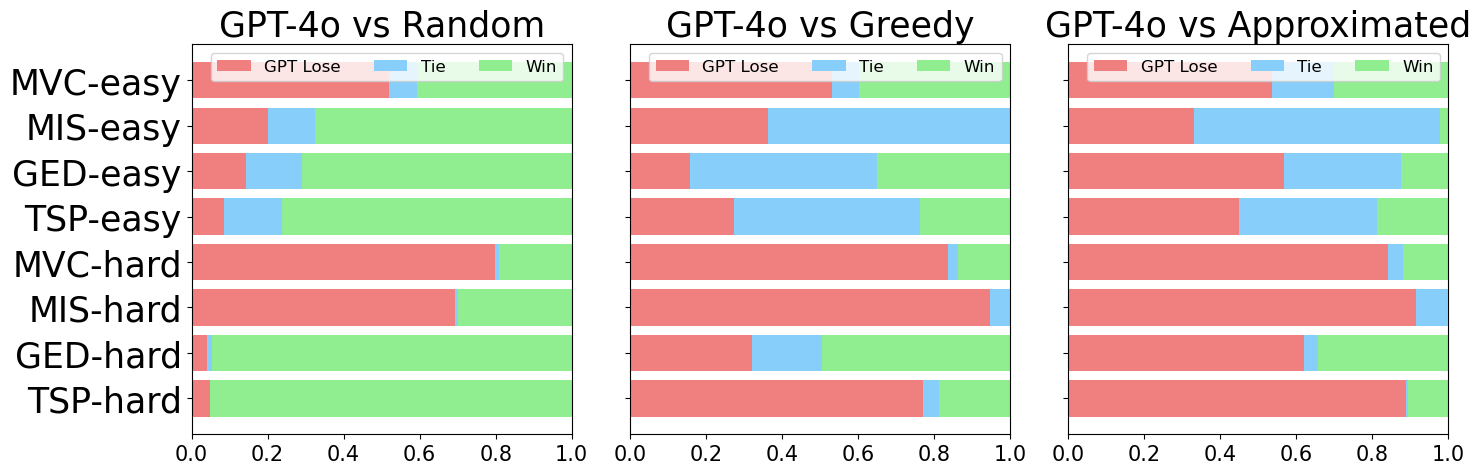

In [7]:
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
categories = ['TSP-hard', 'GED-hard', 'MIS-hard', 'MVC-hard', 'TSP-easy', 'GED-easy', 'MIS-easy', 'MVC-easy']
plt.rcParams.update({'font.size': 15})
data_sets = [
    {
    "better": [0.952, 0.946, 0.298, 0.190, 0.762, 0.710, 0.676, 0.406],
    "equal": [0.000, 0.014, 0.010, 0.012, 0.152, 0.146, 0.124, 0.076],
    "worse": [0.048, 0.040, 0.692, 0.798, 0.086, 0.144, 0.200, 0.518],
    "title": "GPT-4o vs Random"
    },
    {
    "better": [0.188, 0.496, 0.000, 0.136, 0.236, 0.350, 0.000, 0.398],
    "equal": [0.042, 0.182, 0.054, 0.026, 0.490, 0.492, 0.638, 0.070],
    "worse": [0.770, 0.322, 0.946, 0.838, 0.274, 0.158, 0.362, 0.532],
    "title": "GPT-4o vs Greedy"
    },
    {
    "better": [0.106, 0.342, 0.004, 0.120, 0.188, 0.124, 0.022, 0.300],
    "equal": [0.006, 0.038, 0.082, 0.038, 0.362, 0.308, 0.648, 0.164],
    "worse": [0.888, 0.620, 0.914, 0.842, 0.450, 0.568, 0.330, 0.536],
    "title": "GPT-4o vs Approximated"
    }
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, data in zip(axes, data_sets):
    worse = data["worse"]
    equal = data["equal"]
    better = data["better"]
    
    ax.barh(categories, worse, label='GPT Lose', color='lightcoral')
    ax.barh(categories, equal, left=worse, label='Tie', color='lightskyblue')
    ax.barh(categories, better, left=[i+j for i,j in zip(worse, equal)], label='Win', color='lightgreen')
    
    ax.set_title(data["title"], fontsize=25)
    ax.set_xlim(0, 1)
    ax.set_yticklabels(categories, fontsize=25)

for ax in axes:
    ax.legend(loc='upper right', ncol=3, fontsize=12)

plt.tight_layout()
plt.show()
# plt.savefig("bar_chart.pdf")

# TSP small
Task: TSP, method: random
Model: claude, worse: 0.068, equal: 0.158, better: 0.774
Model: gpt4, worse: 0.086, equal: 0.152, better: 0.762
Model: deepseek, worse: 0.120, equal: 0.154, better: 0.726
Model: glm, worse: 0.162, equal: 0.140, better: 0.698
Model: gpt4mini, worse: 0.176, equal: 0.148, better: 0.676
Model: llama, worse: 0.216, equal: 0.134, better: 0.650
Model: llama8b, worse: 0.394, equal: 0.136, better: 0.470
Model: mixtral, worse: 0.394, equal: 0.142, better: 0.464
Model: qwen72b, worse: 0.428, equal: 0.116, better: 0.456
Model: gemma, worse: 0.572, equal: 0.126, better: 0.302

Task: TSP, method: greedy
Model: claude, worse: 0.232, equal: 0.522, better: 0.246
Model: gpt4, worse: 0.274, equal: 0.490, better: 0.236
Model: deepseek, worse: 0.370, equal: 0.420, better: 0.210
Model: glm, worse: 0.410, equal: 0.394, better: 0.196
Model: gpt4mini, worse: 0.424, equal: 0.404, better: 0.172
Model: llama, worse: 0.514, equal: 0.366, better: 0.120
Model: qwen72b, worse: 0.664, equal: 0.190, better: 0.146
Model: mixtral, worse: 0.668, equal: 0.226, better: 0.106
Model: llama8b, worse: 0.724, equal: 0.154, better: 0.122
Model: gemma, worse: 0.774, equal: 0.138, better: 0.088

Task: TSP, method: approximated
Model: claude, worse: 0.420, equal: 0.406, better: 0.174
Model: gpt4, worse: 0.450, equal: 0.362, better: 0.188
Model: deepseek, worse: 0.520, equal: 0.322, better: 0.158
Model: glm, worse: 0.558, equal: 0.310, better: 0.132
Model: gpt4mini, worse: 0.582, equal: 0.294, better: 0.124
Model: llama, worse: 0.678, equal: 0.238, better: 0.084
Model: qwen72b, worse: 0.714, equal: 0.196, better: 0.090
Model: mixtral, worse: 0.760, equal: 0.180, better: 0.060
Model: llama8b, worse: 0.780, equal: 0.156, better: 0.064
Model: gemma, worse: 0.820, equal: 0.130, better: 0.050


# TSP large
Task: TSP, method: random
Model: claude, worse: 0.004, equal: 0.000, better: 0.996
Model: gpt4, worse: 0.048, equal: 0.000, better: 0.952
Model: glm, worse: 0.160, equal: 0.000, better: 0.840
Model: llama, worse: 0.214, equal: 0.000, better: 0.786
Model: gpt4mini, worse: 0.294, equal: 0.000, better: 0.706
Model: deepseek, worse: 0.332, equal: 0.000, better: 0.668
Model: llama8b, worse: 0.694, equal: 0.000, better: 0.306
Model: qwen72b, worse: 0.700, equal: 0.000, better: 0.300
Model: mixtral, worse: 0.756, equal: 0.000, better: 0.244
Model: gemma, worse: 0.966, equal: 0.000, better: 0.034

Task: TSP, method: greedy
Model: claude, worse: 0.584, equal: 0.084, better: 0.332
Model: gpt4, worse: 0.770, equal: 0.042, better: 0.188
Model: glm, worse: 0.946, equal: 0.002, better: 0.052
Model: deepseek, worse: 0.954, equal: 0.002, better: 0.044
Model: llama, worse: 0.986, equal: 0.000, better: 0.014
Model: qwen72b, worse: 0.986, equal: 0.004, better: 0.010
Model: gpt4mini, worse: 0.994, equal: 0.000, better: 0.006
Model: llama8b, worse: 0.998, equal: 0.000, better: 0.002
Model: mixtral, worse: 1.000, equal: 0.000, better: 0.000
Model: gemma, worse: 1.000, equal: 0.000, better: 0.000

Task: TSP, method: approximated
Model: claude, worse: 0.782, equal: 0.010, better: 0.208
Model: gpt4, worse: 0.888, equal: 0.006, better: 0.106
Model: glm, worse: 0.970, equal: 0.004, better: 0.026
Model: deepseek, worse: 0.978, equal: 0.000, better: 0.022
Model: qwen72b, worse: 0.992, equal: 0.000, better: 0.008
Model: llama, worse: 0.994, equal: 0.000, better: 0.006
Model: gpt4mini, worse: 1.000, equal: 0.000, better: 0.000
Model: llama8b, worse: 1.000, equal: 0.000, better: 0.000
Model: mixtral, worse: 1.000, equal: 0.000, better: 0.000
Model: gemma, worse: 1.000, equal: 0.000, better: 0.000



# GED small
Task: GED, method: random
Model: glm, worse: 0.118, equal: 0.160, better: 0.722
Model: gpt4, worse: 0.144, equal: 0.146, better: 0.710
Model: claude, worse: 0.152, equal: 0.126, better: 0.722
Model: llama, worse: 0.156, equal: 0.148, better: 0.696
Model: gemma, worse: 0.240, equal: 0.224, better: 0.536
Model: deepseek, worse: 0.244, equal: 0.140, better: 0.616
Model: qwen72b, worse: 0.260, equal: 0.100, better: 0.640
Model: gpt4mini, worse: 0.306, equal: 0.122, better: 0.572
Model: mixtral, worse: 0.498, equal: 0.124, better: 0.378
Model: llama8b, worse: 0.806, equal: 0.052, better: 0.142

Task: GED, method: greedy
Model: glm, worse: 0.152, equal: 0.468, better: 0.380
Model: gpt4, worse: 0.158, equal: 0.492, better: 0.350
Model: claude, worse: 0.158, equal: 0.432, better: 0.410
Model: llama, worse: 0.288, equal: 0.300, better: 0.412
Model: qwen72b, worse: 0.294, equal: 0.332, better: 0.374
Model: deepseek, worse: 0.318, equal: 0.328, better: 0.354
Model: gpt4mini, worse: 0.320, equal: 0.378, better: 0.302
Model: gemma, worse: 0.482, equal: 0.210, better: 0.308
Model: mixtral, worse: 0.610, equal: 0.214, better: 0.176
Model: llama8b, worse: 0.830, equal: 0.062, better: 0.108

Task: GED, method: approximated
Model: claude, worse: 0.534, equal: 0.336, better: 0.130
Model: qwen72b, worse: 0.542, equal: 0.346, better: 0.112
Model: gpt4, worse: 0.568, equal: 0.308, better: 0.124
Model: glm, worse: 0.572, equal: 0.286, better: 0.142
Model: llama, worse: 0.574, equal: 0.320, better: 0.106
Model: gpt4mini, worse: 0.610, equal: 0.284, better: 0.106
Model: deepseek, worse: 0.626, equal: 0.268, better: 0.106
Model: mixtral, worse: 0.826, equal: 0.114, better: 0.060
Model: llama8b, worse: 0.898, equal: 0.072, better: 0.030
Model: gemma, worse: 0.900, equal: 0.064, better: 0.036

# GED large
Task: GED, method: random
Model: gpt4, worse: 0.040, equal: 0.014, better: 0.946
Model: glm, worse: 0.052, equal: 0.008, better: 0.940
Model: deepseek, worse: 0.164, equal: 0.012, better: 0.824
Model: claude, worse: 0.168, equal: 0.008, better: 0.824
Model: llama, worse: 0.192, equal: 0.008, better: 0.800
Model: gemma, worse: 0.234, equal: 0.012, better: 0.754
Model: gpt4mini, worse: 0.522, equal: 0.008, better: 0.470
Model: mixtral, worse: 0.552, equal: 0.012, better: 0.436
Model: qwen72b, worse: 0.790, equal: 0.002, better: 0.208
Model: llama8b, worse: 0.882, equal: 0.000, better: 0.118

Task: GED, method: greedy
Model: glm, worse: 0.264, equal: 0.216, better: 0.520
Model: gpt4, worse: 0.322, equal: 0.182, better: 0.496
Model: claude, worse: 0.344, equal: 0.132, better: 0.524
Model: deepseek, worse: 0.412, equal: 0.132, better: 0.456
Model: llama, worse: 0.476, equal: 0.106, better: 0.418
Model: gemma, worse: 0.498, equal: 0.072, better: 0.430
Model: gpt4mini, worse: 0.604, equal: 0.102, better: 0.294
Model: mixtral, worse: 0.798, equal: 0.044, better: 0.158
Model: qwen72b, worse: 0.828, equal: 0.032, better: 0.140
Model: llama8b, worse: 0.888, equal: 0.004, better: 0.108

Task: GED, method: approximated
Model: glm, worse: 0.586, equal: 0.038, better: 0.376
Model: claude, worse: 0.590, equal: 0.054, better: 0.356
Model: gpt4, worse: 0.620, equal: 0.038, better: 0.342
Model: deepseek, worse: 0.630, equal: 0.044, better: 0.326
Model: llama, worse: 0.682, equal: 0.034, better: 0.284
Model: gpt4mini, worse: 0.716, equal: 0.030, better: 0.254
Model: gemma, worse: 0.716, equal: 0.034, better: 0.250
Model: qwen72b, worse: 0.874, equal: 0.018, better: 0.108
Model: mixtral, worse: 0.894, equal: 0.012, better: 0.094
Model: llama8b, worse: 0.924, equal: 0.010, better: 0.066

# MVC small
Task: MVC, method: random
Model: glm, worse: 0.366, equal: 0.104, better: 0.530
Model: deepseek, worse: 0.450, equal: 0.092, better: 0.458
Model: gemma, worse: 0.476, equal: 0.142, better: 0.382
Model: llama8b, worse: 0.516, equal: 0.096, better: 0.388
Model: gpt4, worse: 0.518, equal: 0.076, better: 0.406
Model: llama, worse: 0.530, equal: 0.060, better: 0.410
Model: mixtral, worse: 0.604, equal: 0.114, better: 0.282
Model: gpt4mini, worse: 0.622, equal: 0.032, better: 0.346
Model: claude, worse: 0.822, equal: 0.012, better: 0.166
Model: qwen72b, worse: 0.964, equal: 0.008, better: 0.028

Task: MVC, method: greedy
Model: glm, worse: 0.484, equal: 0.204, better: 0.312
Model: deepseek, worse: 0.486, equal: 0.148, better: 0.366
Model: llama, worse: 0.526, equal: 0.074, better: 0.400
Model: gpt4, worse: 0.532, equal: 0.070, better: 0.398
Model: gemma, worse: 0.546, equal: 0.304, better: 0.150
Model: llama8b, worse: 0.558, equal: 0.118, better: 0.324
Model: mixtral, worse: 0.642, equal: 0.204, better: 0.154
Model: gpt4mini, worse: 0.644, equal: 0.082, better: 0.274
Model: claude, worse: 0.822, equal: 0.012, better: 0.166
Model: qwen72b, worse: 0.964, equal: 0.002, better: 0.034

Task: MVC, method: approximated
Model: glm, worse: 0.474, equal: 0.236, better: 0.290
Model: deepseek, worse: 0.514, equal: 0.170, better: 0.316
Model: gpt4, worse: 0.536, equal: 0.164, better: 0.300
Model: llama, worse: 0.536, equal: 0.144, better: 0.320
Model: llama8b, worse: 0.572, equal: 0.158, better: 0.270
Model: gemma, worse: 0.594, equal: 0.256, better: 0.150
Model: gpt4mini, worse: 0.650, equal: 0.096, better: 0.254
Model: mixtral, worse: 0.684, equal: 0.190, better: 0.126
Model: claude, worse: 0.822, equal: 0.050, better: 0.128
Model: qwen72b, worse: 0.964, equal: 0.016, better: 0.020


# MVC large

Task: MVC, method: random
Model: glm, worse: 0.646, equal: 0.016, better: 0.338
Model: deepseek, worse: 0.692, equal: 0.018, better: 0.290
Model: mixtral, worse: 0.780, equal: 0.008, better: 0.212
Model: gpt4mini, worse: 0.782, equal: 0.002, better: 0.216
Model: gpt4, worse: 0.798, equal: 0.012, better: 0.190
Model: llama8b, worse: 0.824, equal: 0.000, better: 0.176
Model: llama, worse: 0.830, equal: 0.000, better: 0.170
Model: gemma, worse: 0.840, equal: 0.002, better: 0.158
Model: claude, worse: 0.914, equal: 0.000, better: 0.086
Model: qwen72b, worse: 0.984, equal: 0.000, better: 0.016

Task: MVC, method: greedy
Model: glm, worse: 0.744, equal: 0.072, better: 0.184
Model: deepseek, worse: 0.810, equal: 0.084, better: 0.106
Model: llama, worse: 0.834, equal: 0.044, better: 0.122
Model: gpt4, worse: 0.838, equal: 0.026, better: 0.136
Model: gpt4mini, worse: 0.846, equal: 0.036, better: 0.118
Model: llama8b, worse: 0.878, equal: 0.020, better: 0.102
Model: mixtral, worse: 0.900, equal: 0.038, better: 0.062
Model: claude, worse: 0.914, equal: 0.006, better: 0.080
Model: gemma, worse: 0.928, equal: 0.024, better: 0.048
Model: qwen72b, worse: 0.994, equal: 0.000, better: 0.006

Task: MVC, method: approximated
Model: glm, worse: 0.752, equal: 0.094, better: 0.154
Model: deepseek, worse: 0.800, equal: 0.088, better: 0.112
Model: gpt4mini, worse: 0.824, equal: 0.062, better: 0.114
Model: gpt4, worse: 0.842, equal: 0.038, better: 0.120
Model: llama, worse: 0.842, equal: 0.038, better: 0.120
Model: llama8b, worse: 0.864, equal: 0.042, better: 0.094
Model: mixtral, worse: 0.900, equal: 0.044, better: 0.056
Model: claude, worse: 0.916, equal: 0.010, better: 0.074
Model: gemma, worse: 0.920, equal: 0.044, better: 0.036
Model: qwen72b, worse: 0.994, equal: 0.000, better: 0.006


## MIS small

Task: MIS, method: random
Model: llama, worse: 0.162, equal: 0.214, better: 0.624
Model: gpt4, worse: 0.200, equal: 0.124, better: 0.676
Model: glm, worse: 0.242, equal: 0.116, better: 0.642
Model: gpt4mini, worse: 0.252, equal: 0.110, better: 0.638
Model: qwen72b, worse: 0.262, equal: 0.218, better: 0.520
Model: claude, worse: 0.268, equal: 0.114, better: 0.618
Model: deepseek, worse: 0.290, equal: 0.156, better: 0.554
Model: mixtral, worse: 0.398, equal: 0.162, better: 0.440
Model: llama8b, worse: 0.440, equal: 0.100, better: 0.460
Model: gemma, worse: 0.678, equal: 0.056, better: 0.266

Task: MIS, method: greedy
Model: claude, worse: 0.320, equal: 0.680, better: 0.000
Model: gpt4, worse: 0.362, equal: 0.638, better: 0.000
Model: glm, worse: 0.426, equal: 0.572, better: 0.002
Model: gpt4mini, worse: 0.572, equal: 0.428, better: 0.000
Model: llama, worse: 0.632, equal: 0.368, better: 0.000
Model: deepseek, worse: 0.638, equal: 0.362, better: 0.000
Model: llama8b, worse: 0.716, equal: 0.280, better: 0.004
Model: gemma, worse: 0.788, equal: 0.212, better: 0.000
Model: mixtral, worse: 0.884, equal: 0.116, better: 0.000
Model: qwen72b, worse: 0.962, equal: 0.038, better: 0.000

Task: MIS, method: approximated
Model: claude, worse: 0.302, equal: 0.680, better: 0.018
Model: gpt4, worse: 0.330, equal: 0.648, better: 0.022
Model: glm, worse: 0.390, equal: 0.588, better: 0.022
Model: gpt4mini, worse: 0.546, equal: 0.446, better: 0.008
Model: llama, worse: 0.612, equal: 0.382, better: 0.006
Model: deepseek, worse: 0.618, equal: 0.374, better: 0.008
Model: llama8b, worse: 0.694, equal: 0.292, better: 0.014
Model: gemma, worse: 0.788, equal: 0.212, better: 0.000
Model: mixtral, worse: 0.870, equal: 0.126, better: 0.004
Model: qwen72b, worse: 0.944, equal: 0.050, better: 0.006


## MIS large


Task: MIS, method: random
Model: llama, worse: 0.540, equal: 0.034, better: 0.426
Model: gpt4mini, worse: 0.558, equal: 0.038, better: 0.404
Model: qwen72b, worse: 0.568, equal: 0.042, better: 0.390
Model: glm, worse: 0.652, equal: 0.004, better: 0.344
Model: mixtral, worse: 0.688, equal: 0.028, better: 0.284
Model: gpt4, worse: 0.692, equal: 0.010, better: 0.298
Model: claude, worse: 0.738, equal: 0.010, better: 0.252
Model: llama8b, worse: 0.854, equal: 0.004, better: 0.142
Model: deepseek, worse: 0.872, equal: 0.006, better: 0.122
Model: gemma, worse: 0.940, equal: 0.000, better: 0.060

Task: MIS, method: greedy
Model: claude, worse: 0.922, equal: 0.078, better: 0.000
Model: gpt4, worse: 0.946, equal: 0.054, better: 0.000
Model: glm, worse: 0.962, equal: 0.038, better: 0.000
Model: deepseek, worse: 0.968, equal: 0.032, better: 0.000
Model: llama, worse: 0.972, equal: 0.026, better: 0.002
Model: gpt4mini, worse: 0.982, equal: 0.018, better: 0.000
Model: llama8b, worse: 0.990, equal: 0.010, better: 0.000
Model: qwen72b, worse: 0.990, equal: 0.010, better: 0.000
Model: mixtral, worse: 0.990, equal: 0.008, better: 0.002
Model: gemma, worse: 0.994, equal: 0.006, better: 0.000

Task: MIS, method: approximated
Model: claude, worse: 0.904, equal: 0.088, better: 0.008
Model: gpt4, worse: 0.914, equal: 0.082, better: 0.004
Model: glm, worse: 0.940, equal: 0.054, better: 0.006
Model: llama, worse: 0.956, equal: 0.038, better: 0.006
Model: deepseek, worse: 0.960, equal: 0.036, better: 0.004
Model: gpt4mini, worse: 0.976, equal: 0.024, better: 0.000
Model: qwen72b, worse: 0.978, equal: 0.018, better: 0.004
Model: llama8b, worse: 0.984, equal: 0.014, better: 0.002
Model: mixtral, worse: 0.988, equal: 0.006, better: 0.006
Model: gemma, worse: 0.994, equal: 0.006, better: 0.000 -->
